# COMS 6998 - Practical Deep Learning System Performance

## Assignment 1
* **Name**: Zach Lawless
* **UNI**: ztl2103

### Problem 1: Linear Separability (10 points)

#### Q1 (2 points)

In [1]:
# import packages needed to answer this question
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

Given the dataset provided in the question, a dataframe for visualation purposes can be created.

In [2]:
x1 = np.array([(-1, -1),
               (1, 1),
               (-3, -3),
               (4, 4)])
y1 = np.array(['class_1'] * 4)

x2 = np.array([(-1, 1),
               (1, -1),
               (-5, 2),
               (4, -8)])
y2 = np.array(['class_2'] * 4)

In [3]:
df = pd.DataFrame(data=np.vstack((x1, x2)), columns=['x_1', 'x_2'])
df['y'] = np.hstack((y1, y2))
df

,x_1,x_2,y
0,-1,-1,class_1
1,1,1,class_1
2,-3,-3,class_1
3,4,4,class_1
4,-1,1,class_2
5,1,-1,class_2
6,-5,2,class_2
7,4,-8,class_2


A plot of the points colored by the class can be generated now using `seaborn`.

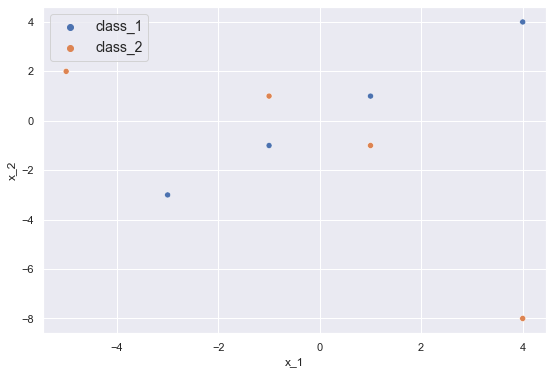

In [4]:
fig, axs = plt.subplots(figsize=(9, 6))
sns.scatterplot(data=df, x='x_1', y='x_2', hue='y')
plt.legend(fontsize=14)

As visible above, this dataset is not linearly seperable. A linear classifier can be trained, but perfect accuracy cannot be achieved without transforming the original data with some kernel transformation that makes the data entirely linearly separable.

#### Q2 (4 points)

You can define $z=x_1 * x_2$ which would make class 1 and class 2 linearly separable. The below visualization demonstrates that. 

In [5]:
df['z'] = df['x_1'] * df['x_2']

# create a dummy feature for visualization purposes
df['zero'] = 0

df

,x_1,x_2,y,z,zero
0,-1,-1,class_1,1,0
1,1,1,class_1,1,0
2,-3,-3,class_1,9,0
3,4,4,class_1,16,0
4,-1,1,class_2,-1,0
5,1,-1,class_2,-1,0
6,-5,2,class_2,-10,0
7,4,-8,class_2,-32,0


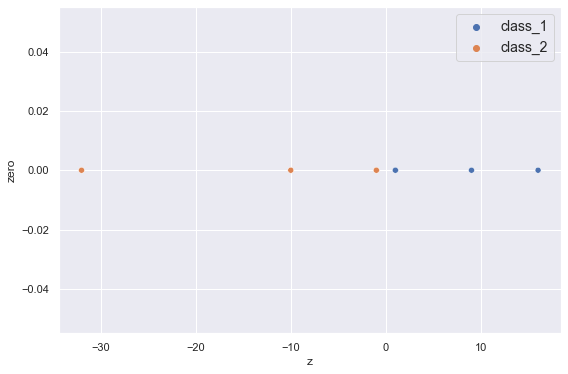

In [6]:
fig, axs = plt.subplots(figsize=(9, 6))
sns.scatterplot(data=df, x='z', y='zero', hue='y')
plt.legend(fontsize=14)

#### Q3 (2 points)

The separating hyperplane is $z=0$, and is demonstrated visually below.

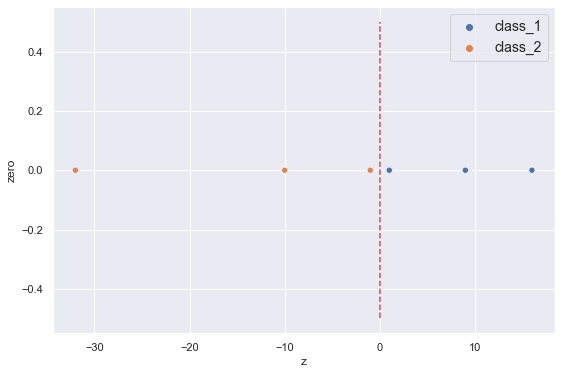

In [7]:
fig, axs = plt.subplots(figsize=(9, 6))
sns.scatterplot(data=df, x='z', y='zero', hue='y')
plt.vlines(0, ymin=-0.5, ymax=0.5, colors='r', linestyles='dashed')
plt.legend(fontsize=14)

#### Q4 (2 points)

Non-linear transformations are important in classification problems because they can transform linearly inseparable data into linearly separable in some hyperspace. This leads to improvements in classification accuracy.

### Problem 2: Bias Variance Tradeoff, Regularization (40 points)

#### Q1 (5 points)

Using [the provided blog post](https://dustinstansbury.github.io/theclevermachine/bias-variance-tradeoff) as reference:

We can rewrite the formula for $MSE$ by substituting $y(x)=f(x)+\epsilon$ and $\hat{y}=g(x)$, as well as use the expectation $\mathop{\mathbb{E}}$ in place of the average of the sum $\frac{1}{t}\sum^{t}_{i=1}$.

$$ MSE = \mathop{\mathbb{E}}\Big[(y-\hat{y})^2\Big] $$

We can expand the squared error term using polynomial expansion with some properties of expectations such as constant multiplier and the expected value of a squared random variable to get the following form:

$$ \mathop{\mathbb{E}}\Big[(y-\hat{y})^2\Big] = \mathop{\mathbb{E}}\Big[y^2-2y\hat{y}+\hat{y}^2\Big] $$

$$ = \mathop{\mathbb{E}}\Big[y^2\Big] -2\mathop{\mathbb{E}}\Big[y\hat{y}\Big] + \mathop{\mathbb{E}}\Big[\hat{y}^2\Big] $$

$$ ... $$

$$ = \mathop{\mathbb{E}}[(\hat{y}-\mathop{\mathbb{E}}[\hat{y}])^2] + (\mathop{\mathbb{E}}[\hat{y}(x)] - f(x))^2 + \mathop{\mathbb{E}}[(y-f(x))^2] $$

The first term in the above equation is equal to the variance of the estimator, the second equal to the squared bias of the estimator, and the third equal to the variance of the observation noise. Therefore, we can rewrite as:

$$ MSE = {Bias}^2+Variance+Noise $$

And the proof is complete.

#### Q2 (5 points)

Define the necessary functions as follows:

In [8]:
# define base function
def f(x):
    return x + np.sin(1.5 * x)

# define epsilon error function
def epsilon(n):
    return np.random.normal(loc=0, scale=0.3, size=n)

# define estimate function
def y(x):
    return f(x) + epsilon(len(x))

Generate the random points and a grid for plotting.

In [9]:
# generate the random points and order
SIZE = 20
x = np.random.random_sample(SIZE) * 10  # scales random points [0, 10)
x = np.sort(x)  # sort the random points ascending
x_grid = np.linspace(start=0, stop=10, num=100)

Calculate the estimate and the true value and plot.

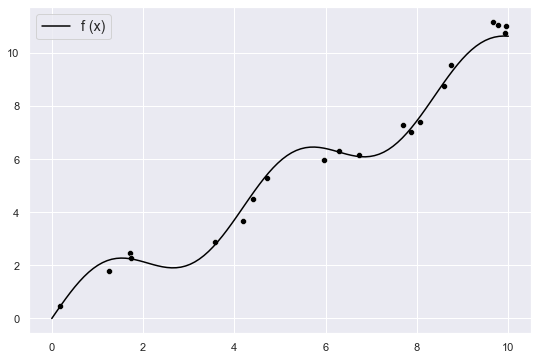

In [10]:
# get the estimate y(x) and the true f(x)
y_x = y(x)
f_x = f(x_grid)

# plot
fig, axs = plt.subplots(figsize=(9, 6))
sns.scatterplot(x=x, y=y_x, marker='o', color='black')
sns.lineplot(x=x_grid, y=f_x, color='black', label='f (x)')
plt.legend(fontsize=14)

#### Q3 (10 points)

Create the base plot, and iterate through the varying polynomial degree fits and plot their function.

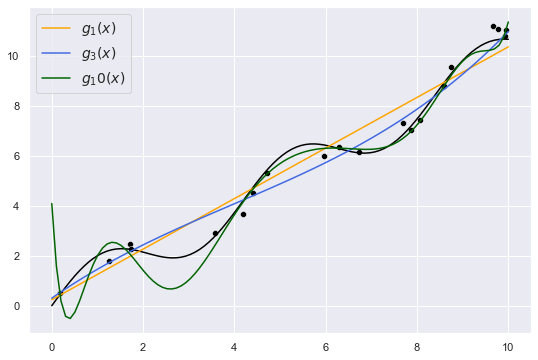

In [11]:
# plot
fig, axs = plt.subplots(figsize=(9, 6))
sns.scatterplot(x=x, y=y_x, marker='o', color='black')
sns.lineplot(x=x_grid, y=f_x, color='black')

# loop through varying degrees, fit and plot
polynomial_degrees = [1, 3, 10]
theta = {}
fit = {}
POLYNOMIAL_FIT_COLORS = ['orange', 'royalblue', 'darkgreen']

for ii, degree in enumerate(polynomial_degrees):
    theta[degree] = np.polyfit(x, y(x), degree)
    fit[degree] = np.polyval(theta[degree], x_grid)
    plt.plot(x_grid, fit[degree], POLYNOMIAL_FIT_COLORS[ii], label="$g_{d}(x)$".format(d=degree))
plt.legend(fontsize=14)

From the plot above, estimators $g_{1}(x)$ is underfitting and $g_{10}(x)$ is overfitting.

#### Q4 (10 points)

Define variables for experiment

In [12]:
n_observations_per_dataset = 50
n_datasets = 100
max_poly_degree = 15
model_poly_degrees = range(1, max_poly_degree + 1)
percent_train = .8
n_train = int(np.ceil(n_observations_per_dataset * percent_train))

Set up logging

In [13]:
from collections import defaultdict

theta_hat = defaultdict(list)
pred_train = defaultdict(list)
pred_test = defaultdict(list)
train_errors = defaultdict(list)
test_errors = defaultdict(list)

Loop over each degree, fit, and log

In [14]:
def error_function(pred, actual):
    return (pred - actual) ** 2

# Loop over datasets
for dataset in range(n_datasets):
    
    # create x_train and x_test
    x = np.random.random_sample(n_observations_per_dataset) * 10
    x_train = x[:n_train]
    x_test = x[n_train:]

    # Simulate training/testing targets
    y_train = y(x_train)
    y_test = y(x_test)

    # Loop over model complexities
    for degree in model_poly_degrees:
        # Train model
        tmp_theta_hat = np.polyfit(x_train, y_train, degree)

        # Make predictions on train set
        tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
        pred_train[degree].append(tmp_pred_train)

        # Test predictions
        tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
        pred_test[degree].append(tmp_pred_test)

        # Mean Squared Error for train and test sets
        train_errors[degree].append(np.mean(error_function(tmp_pred_train, y_train)))
        test_errors[degree].append(np.mean(error_function(tmp_pred_test, y_test)))

Create functions for squared bias and variance

In [15]:
def calculate_estimator_bias_squared(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (E[g(x)] - f(x))^2, averaged across all trials
    return np.mean((average_model_prediction - f(x_test)) ** 2)


def calculate_estimator_variance(pred_test):
    pred_test = np.array(pred_test)
    average_model_prediction = pred_test.mean(0)  # E[g(x)]

    # (g(x) - E[g(x)])^2, averaged across all trials
    return np.mean((pred_test - average_model_prediction) ** 2)

Calculate squared bias and variance for each degree

In [16]:
complexity_train_error = []
complexity_test_error = []
bias_squared = []
variance = []
for degree in model_poly_degrees:
    complexity_train_error.append(np.mean(train_errors[degree]))
    complexity_test_error.append(np.mean(test_errors[degree]))
    bias_squared.append(calculate_estimator_bias_squared(pred_test[degree]))
    variance.append(calculate_estimator_variance(pred_test[degree]))

Determine which degree model is the best based on the minimum test error

In [17]:
best_model_degree = model_poly_degrees[np.argmin(complexity_test_error)]
print(f"the best model is degree {best_model_degree}")

the best model is degree 8


Visualize

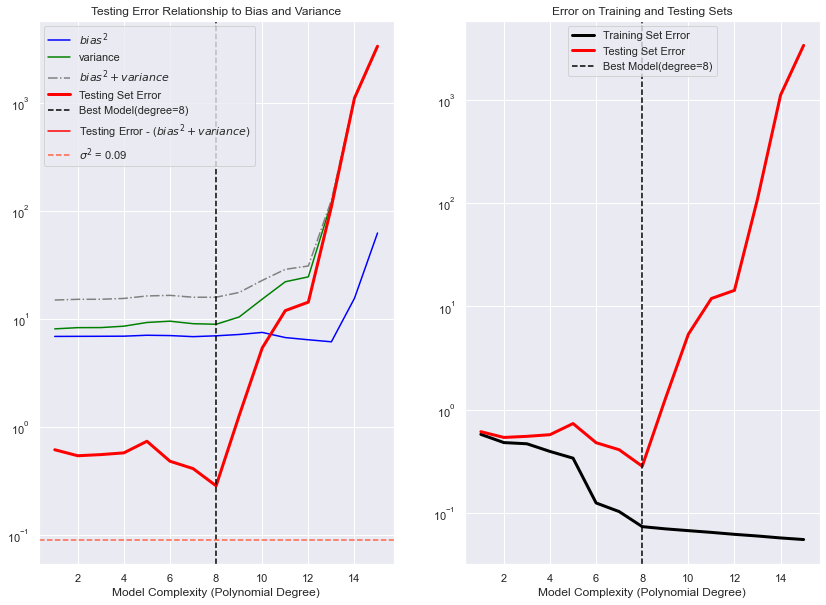

In [18]:
DATA_COLOR = 'black'
ERROR_COLOR = 'red'
NOISE_STD = 0.3

# Visualizations
fig, axs = plt.subplots(1, 2, figsize=(14, 10))

## Plot Bias^2 + variance
plt.sca(axs[0])
plt.plot(model_poly_degrees, bias_squared, color='blue', label='$bias^2$')
plt.plot(model_poly_degrees, variance, color='green', label='variance')
plt.plot(model_poly_degrees, np.array(bias_squared) + np.array(variance),  linestyle='-.', color='gray', label='$bias^2 + variance$')
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.plot(model_poly_degrees, np.array(complexity_test_error) - (np.array(bias_squared) + np.array(variance)), color='red', label='Testing Error - ($bias^2 + variance$)')
plt.axhline(NOISE_STD **2, color='tomato', linestyle='--', label=f'$\sigma^2$ = {round(NOISE_STD**2, 3)}')

plt.xlabel('Model Complexity (Polynomial Degree)')
plt.legend()
plt.title('Testing Error Relationship to Bias and Variance')
plt.yscale('log')

## Plot Train / Test Set Error
plt.sca(axs[1])
plt.plot(model_poly_degrees, complexity_train_error, label='Training Set Error', linewidth=3, color=DATA_COLOR)
plt.plot(model_poly_degrees, complexity_test_error, label='Testing Set Error', linewidth=3, color=ERROR_COLOR)
plt.axvline(best_model_degree, linestyle='--', color='black', label=f'Best Model(degree={best_model_degree})')
plt.xlabel('Model Complexity (Polynomial Degree)')
plt.title('Error on Training and Testing Sets')
plt.legend(loc='upper center')
plt.yscale('log')

Based on the plots of squared bias, variance, and error above for each degree of polynomial from 1 to 15, as well as the numerical calculation for the minimum test error, $g_{6}(x)$ is the best model.

#### Q5 (10 points)

Showing the metrics associated with the degree-10 non-regularized model

In [19]:
focus_degree = 10

print(f"""
--- Degree 10 Non-Regularized Metrics ---

Train MSE: {complexity_train_error[focus_degree-1]}
Test MSE: {complexity_test_error[focus_degree-1]}
Bias Squared: {bias_squared[focus_degree-1]}
Variance: {variance[focus_degree-1]}
""")


--- Degree 10 Non-Regularized Metrics ---

Train MSE: 0.06738843588312507
Test MSE: 5.376079569628409
Bias Squared: 7.490802795216512
Variance: 15.242698901380944



Fitting the 10-degree polynomial with regularization on 100 datasets of size 50, split into train and test

In [20]:
def error_function_L2(pred, actual, weights, l=1e2):
    se = (pred - actual) ** 2
    reg = l * np.sum(weights ** 2)
    return se + reg

pred_train = []
pred_test = []
train_errors = []
test_errors = []

# Loop over datasets
for dataset in range(n_datasets):
    
    # create x_train and x_test
    x = np.random.random_sample(n_observations_per_dataset) * 10
    x_train = x[:n_train]
    x_test = x[n_train:]

    # Simulate training/testing targets
    y_train = y(x_train)
    y_test = y(x_test)

    # Train model
    tmp_theta_hat = np.polyfit(x_train, y_train, focus_degree)
    
    # Make predictions on train set
    tmp_pred_train = np.polyval(tmp_theta_hat, x_train)
    pred_train.append(tmp_pred_train)
    
    # Test predictions
    tmp_pred_test = np.polyval(tmp_theta_hat, x_test)
    pred_test.append(tmp_pred_test)
    
    # Mean Squared Error + L2 regularization for train and test sets
    train_errors.append(np.mean(error_function_L2(tmp_pred_train, y_train, tmp_theta_hat)))
    test_errors.append(np.mean(error_function_L2(tmp_pred_test, y_test, tmp_theta_hat)))

In [21]:
complexity_train_error = np.mean(train_errors)
complexity_test_error = np.mean(test_errors)
bias_squared = calculate_estimator_bias_squared(pred_test)
variance = calculate_estimator_variance(pred_test)

In [22]:
print(f"""
--- Degree 10 Non-Regularized Metrics ---

Train MSE: {complexity_train_error}
Test MSE: {complexity_test_error}
Bias Squared: {bias_squared}
Variance: {variance}
""")


--- Degree 10 Non-Regularized Metrics ---

Train MSE: 299404.0265965669
Test MSE: 299406.7604919832
Bias Squared: 9.007274940534558
Variance: 11.401447748109938



The MSE is just about equal now  between training and test due to adding the L2 regularization terms, as opposed to an overfit degree-10 model without regularization. The regularized model has higher bias. The lambda hyperparameter greatly impacts the performance of the L2 model.

### Problem 3: OpenML, Algorithmic Performance Scaling (25 points)

Using the [Mushroom](https://www.openml.org/d/24) (`dataset_id=24`) and [Letter](https://www.openml.org/d/6) (`dataset_id=6`) datasets.

Install the OpenML python library for pulling data.

In [23]:
# Install openml package if not already installed
# !pip install openml

#### Q1 (5 points)

Import the `openml` package and pull the data datasets.

In [24]:
import openml
openml_mushroom = openml.datasets.get_dataset(24)
openml_letters = openml.datasets.get_dataset(6)

Summarizing the Mushroom dataset.

In [25]:
# get the mushroom dataframe
df_mushroom = openml_mushroom.get_data()[0]
df_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,x,s,n,t,p,f,c,n,k,e,...,w,w,p,w,o,p,k,s,u,p
1,x,s,y,t,a,f,c,b,k,e,...,w,w,p,w,o,p,n,n,g,e
2,b,s,w,t,l,f,c,b,n,e,...,w,w,p,w,o,p,n,n,m,e
3,x,y,w,t,p,f,c,n,n,e,...,w,w,p,w,o,p,k,s,u,p
4,x,s,g,f,n,f,w,b,k,t,...,w,w,p,w,o,e,n,a,g,e


In [26]:
# get some summary stats about the dataframe
df_mushroom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   cap-shape                 8124 non-null   category
 1   cap-surface               8124 non-null   category
 2   cap-color                 8124 non-null   category
 3   bruises%3F                8124 non-null   category
 4   odor                      8124 non-null   category
 5   gill-attachment           8124 non-null   category
 6   gill-spacing              8124 non-null   category
 7   gill-size                 8124 non-null   category
 8   gill-color                8124 non-null   category
 9   stalk-shape               8124 non-null   category
 10  stalk-root                5644 non-null   category
 11  stalk-surface-above-ring  8124 non-null   category
 12  stalk-surface-below-ring  8124 non-null   category
 13  stalk-color-above-ring    8124 non-null   catego

In [27]:
# determine the target distribution
df_mushroom['class'].value_counts()

e    4208
p    3916
Name: class, dtype: int64

Summarizing the Letters dataset.

In [28]:
# get the letters dataframe
df_letters = openml_letters.get_data()[0]
df_letters.head()

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,class
0,2,4,4,3,2,7,8,2,9,11,7,7,1,8,5,6,Z
1,4,7,5,5,5,5,9,6,4,8,7,9,2,9,7,10,P
2,7,10,8,7,4,8,8,5,10,11,2,8,2,5,5,10,S
3,4,9,5,7,4,7,7,13,1,7,6,8,3,8,0,8,H
4,6,7,8,5,4,7,6,3,7,10,7,9,3,8,3,7,H


In [29]:
# get some summary stats about the dataframe
df_letters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   x-box   20000 non-null  int64   
 1   y-box   20000 non-null  int64   
 2   width   20000 non-null  int64   
 3   high    20000 non-null  int64   
 4   onpix   20000 non-null  int64   
 5   x-bar   20000 non-null  int64   
 6   y-bar   20000 non-null  int64   
 7   x2bar   20000 non-null  int64   
 8   y2bar   20000 non-null  int64   
 9   xybar   20000 non-null  int64   
 10  x2ybr   20000 non-null  int64   
 11  xy2br   20000 non-null  int64   
 12  x-ege   20000 non-null  int64   
 13  xegvy   20000 non-null  int64   
 14  y-ege   20000 non-null  int64   
 15  yegvx   20000 non-null  int64   
 16  class   20000 non-null  category
dtypes: category(1), int64(16)
memory usage: 2.5 MB


In [30]:
# determine the target distribution
df_letters['class'].value_counts()

U    813
D    805
P    803
T    796
M    792
A    789
X    787
Y    786
Q    783
N    783
F    775
G    773
E    768
B    766
V    764
L    761
R    758
I    755
O    753
W    752
S    748
J    747
K    739
C    736
H    734
Z    734
Name: class, dtype: int64

In summary, the characterists of each dataset are listed in the table below.

|Dataset|n_features|n_instances|n_classes|n_numerical|n_categorical
|-------|----------|-----------|---------|-----------|------------|
|Mushroom|22|8124|2|0|22|
|Letters|16|20000|26|16|0|

#### Q2 (15 points)

Drop the `stalk-root` from the Mushroom dataframe as it contains mostly null values, and encode all of the categorical features in the Mushroom dataset.

In [31]:
df_mushroom = df_mushroom.drop(columns=['stalk-root'])

In [32]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
encoder = OrdinalEncoder()
df_mushroom = pd.DataFrame(data=encoder.fit_transform(df_mushroom), columns=df_mushroom.columns)
df_mushroom.head()

,cap-shape,cap-surface,cap-color,bruises%3F,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,class
0,5.0,2.0,4.0,1.0,6.0,1.0,0.0,1.0,4.0,0.0,...,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0,1.0
1,5.0,2.0,9.0,1.0,0.0,1.0,0.0,0.0,4.0,0.0,...,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,1.0,0.0
2,0.0,2.0,8.0,1.0,3.0,1.0,0.0,0.0,5.0,0.0,...,7.0,7.0,0.0,2.0,1.0,4.0,3.0,2.0,3.0,0.0
3,5.0,3.0,8.0,1.0,6.0,1.0,0.0,1.0,5.0,0.0,...,7.0,7.0,0.0,2.0,1.0,4.0,2.0,3.0,5.0,1.0
4,5.0,2.0,3.0,0.0,5.0,1.0,1.0,0.0,4.0,1.0,...,7.0,7.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0


Split the two datasets in to train and test.

In [33]:
from sklearn.model_selection import train_test_split

TEST_PERC = 0.2
df_mushroom_train, df_mushroom_test = train_test_split(df_mushroom, test_size=TEST_PERC)
df_letters_train, df_letters_test = train_test_split(df_letters, test_size=TEST_PERC)

print(f"MUSHROOM: train shape={df_mushroom_train.shape}, test shape={df_mushroom_test.shape}")
print(f"LETTERS: train shape={df_letters_train.shape}, test shape={df_letters_test.shape}")

MUSHROOM: train shape=(6499, 22), test shape=(1625, 22)
LETTERS: train shape=(16000, 17), test shape=(4000, 17)


In [34]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from time import time

EXP_LOG = []
DATASETS = ['mushroom', 'letters']
MODELS = ['RandomForestClassifier', 'GradientBoostingClassifier']
TRAIN_PERC = np.linspace(0.1, 1.0, 10)

Perform experiment.

In [35]:
# silence warnings
import warnings
warnings.filterwarnings('ignore')

In [36]:
for tp in TRAIN_PERC:
    print(round(tp, 2))
    
    # split each dataset
    if tp < 1:
        df_mushroom_train_tp, _ = train_test_split(df_mushroom_train, train_size=tp)
        df_letters_train_tp, _ = train_test_split(df_letters_train, train_size=tp)
    else:
        df_mushroom_train_tp = df_mushroom_train
        df_letters_train_tp = df_letters_train
        
    print(f'  {df_mushroom_train_tp.shape}, {df_letters_train_tp.shape}')
                
    for dataset in DATASETS:
        
        if dataset == 'mushroom':
            df_exp = df_mushroom_train_tp
            df_exp_train_y = df_exp[['class']].values
            df_exp_train_X = df_exp.drop(columns=['class'])
            df_exp_test_y = df_mushroom_test[['class']].values
            df_exp_test_X = df_mushroom_test[[col for col in df_mushroom_test.columns if col != 'class']]
        else:
            df_exp = df_letters_train_tp
            df_exp_train_y = df_exp[['class']].values
            df_exp_train_X = df_exp.drop(columns=['class'])
            df_exp_test_y = df_letters_test[['class']].values
            df_exp_test_X = df_letters_test[[col for col in df_letters_test.columns if col != 'class']]
            
        for mdl in MODELS:
            
            if mdl == 'RandomForestClassifier':
                # train RandomForestClassifier
                clf = RandomForestClassifier(n_estimators=50)
            else:
                # train GradientBoostingClassifier
                clf = GradientBoostingClassifier(n_estimators=10)
                
            t1 = time()
            clf.fit(df_exp_train_X, df_exp_train_y)
            exp_time = time() - t1
            
            exp_train_pred = clf.predict(df_exp_train_X)
            exp_test_pred = clf.predict(df_exp_test_X)
            train_acc = np.mean(exp_train_pred == df_exp_train_y)
            test_acc = np.mean(exp_test_pred == df_exp_test_y)
            
            print(f'    {train_acc, test_acc}')
            
            exp_metrics = {
                'Percent of Training Dataset Used': tp,
                'Dataset': dataset,
                'Model': mdl,
                'Train Time': exp_time,
                'Train Accuracy': train_acc,
                'Test Accuracy': test_acc
            }
            
            EXP_LOG.append(exp_metrics)

0.1
  (649, 22), (1600, 17)
    (0.5004285364944527, 0.5012116449704141)
    (0.5006991911225283, 0.5018698224852071)
    (0.03884609375, 0.0386056875)
    (0.039030078125, 0.038586)
0.2
  (1299, 22), (3200, 17)
    (0.5024537735843466, 0.5011817278106508)
    (0.5038559299182589, 0.502916923076923)
    (0.0386767578125, 0.0386194375)
    (0.038737109375, 0.038584)
0.3
  (1949, 22), (4800, 17)
    (0.5004276574454648, 0.5011817278106508)
    (0.5009528507995443, 0.5019894911242604)
    (0.03863185763888889, 0.0386105625)
    (0.038880121527777776, 0.038447625)
0.4
  (2599, 22), (6400, 17)
    (0.5006680433664885, 0.5011817278106508)
    (0.5009633888548308, 0.5018399053254438)
    (0.038582763671875, 0.038604875)
    (0.03864052734375, 0.03841025)
0.5
  (3249, 22), (8000, 17)
    (0.5003922413421522, 0.5011817278106508)
    (0.5007370688956926, 0.5018399053254438)
    (0.038570125, 0.038601625)
    (0.038673421875, 0.038433625)
0.6
  (3899, 22), (9600, 17)
    (0.50069151170939, 0.5011

In [37]:
df_exp_results = pd.DataFrame(EXP_LOG)
df_exp_results.head(10)

,Percent of Training Dataset Used,Dataset,Model,Train Time,Train Accuracy,Test Accuracy
0,0.1,mushroom,RandomForestClassifier,0.060386,0.500429,0.501212
1,0.1,mushroom,GradientBoostingClassifier,0.010260,0.500699,0.501870
2,0.1,letters,RandomForestClassifier,0.136937,0.038846,0.038606
3,0.1,letters,GradientBoostingClassifier,0.527463,0.039030,0.038586
4,0.2,mushroom,RandomForestClassifier,0.058064,0.502454,0.501182
5,0.2,mushroom,GradientBoostingClassifier,0.012116,0.503856,0.502917
6,0.2,letters,RandomForestClassifier,0.187462,0.038677,0.038619
7,0.2,letters,GradientBoostingClassifier,0.910283,0.038737,0.038584
8,0.3,mushroom,RandomForestClassifier,0.062009,0.500428,0.501182
9,0.3,mushroom,GradientBoostingClassifier,0.015370,0.500953,0.501989


Plot results.

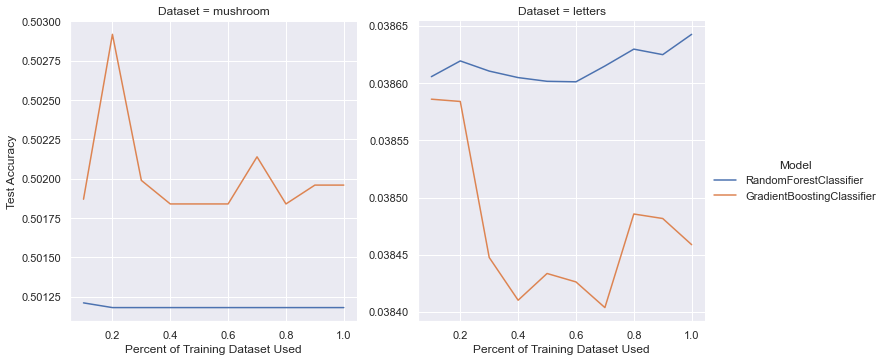

In [38]:
sns.relplot(
    x='Percent of Training Dataset Used',
    y='Test Accuracy',
    data=df_exp_results,
    col='Dataset',
    hue='Model',
    kind='line',
    facet_kws={'sharey': False}
)

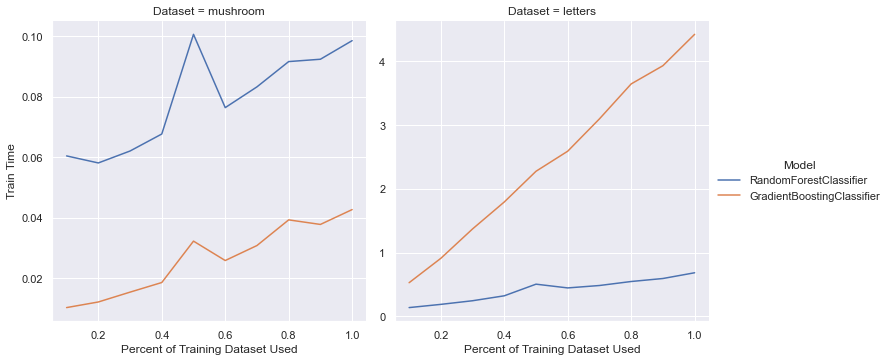

In [39]:
sns.relplot(
    x='Percent of Training Dataset Used',
    y='Train Time',
    data=df_exp_results,
    col='Dataset',
    hue='Model',
    kind='line',
    facet_kws={'sharey': False}
)

#### Q3 (5 points)

The two classifiers perform similarily on both datasets. The accuracy differences are so small that they are pretty much negligible. The two models trained in gnerally the same amount of time for the Mushroom dataset (orders of milliseconds), but the Random Forest model trained much faster on the much larger Letters dataset.

### Problem 4: Precision, Recall, ROC (25 points)

#### Q1 (5 points)

True negative does matter in ROC space but not in PR space. Each point in a ROC curve corresponds to each point in a PR curve because true negative can be determined via knowing the other three values of the confusion matrix. Because of this, there is a one-to-one mapping between confusion matrices and points in PR space, and a one-to-one mapping between points in ROC space and PR space, making it possible to translate between the two.

#### Q2 (10 points)

Using the [Titanic](https://www.openml.org/d/40945) (`dataset_id=40945`).

In [40]:
openml_titanic = openml.datasets.get_dataset(40945)
titanic_df = openml_titanic.get_data()[0]
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


In [41]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   pclass     1309 non-null   float64 
 1   survived   1309 non-null   category
 2   name       1309 non-null   object  
 3   sex        1309 non-null   category
 4   age        1046 non-null   float64 
 5   sibsp      1309 non-null   float64 
 6   parch      1309 non-null   float64 
 7   ticket     1309 non-null   object  
 8   fare       1308 non-null   float64 
 9   cabin      295 non-null    object  
 10  embarked   1307 non-null   category
 11  boat       486 non-null    object  
 12  body       121 non-null    float64 
 13  home.dest  745 non-null    object  
dtypes: category(3), float64(6), object(5)
memory usage: 116.7+ KB


Using `pclass`, `sex`, `age`, `sibsp`, and `parch` as features to predict `survived`, and dropping rows with null values.

In [42]:
titanic_df = titanic_df[['pclass', 'sex', 'age', 'sibsp', 'parch', 'survived']].dropna().reset_index(drop=True)
titanic_df['survived'] = titanic_df['survived'].astype(int)
titanic_df.head()

,pclass,sex,age,sibsp,parch,survived
0,1.0,female,29.0000,0.0,0.0,1
1,1.0,male,0.9167,1.0,2.0,1
2,1.0,female,2.0000,1.0,2.0,0
3,1.0,male,30.0000,1.0,2.0,0
4,1.0,female,25.0000,1.0,2.0,0


Encode `sex`.

In [43]:
titanic_df['sex_enc'] = titanic_df['sex'].apply(lambda x: 1 if x == 'male' else 0)
titanic_df.drop(columns=['sex'], inplace=True)
titanic_df.head()

,pclass,age,sibsp,parch,survived,sex_enc
0,1.0,29.0000,0.0,0.0,1,0
1,1.0,0.9167,1.0,2.0,1,1
2,1.0,2.0000,1.0,2.0,0,0
3,1.0,30.0000,1.0,2.0,0,1
4,1.0,25.0000,1.0,2.0,0,0


Perform train test split and train the `AdaBoostClassifier` and `LogisticRegression` classifier.

In [44]:
df_train, df_test = train_test_split(titanic_df, test_size=0.2)
print(df_train.shape, df_test.shape)

(836, 6) (210, 6)


In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

In [46]:
target_col = 'survived'
feature_cols = [col for col in df_train.columns if col!=target_col]

X_train = df_train[feature_cols].values
y_train = np.array(df_train[target_col].values)

X_test = df_test[feature_cols].values
y_test = np.array(df_test[target_col].values)

In [47]:
lr_clf = LogisticRegression()
ab_clf = AdaBoostClassifier()

In [48]:
lr_clf.fit(X_train, y_train)
y_pred_lr = lr_clf.predict(X_test)
y_scores_lr = lr_clf.decision_function(X_test)
y_scores_lr[:5]

array([ 2.27789068,  0.29508564, -2.11933319,  0.33296726, -1.8162802 ])

In [49]:
ab_clf.fit(X_train, y_train)
y_pred_ab = ab_clf.predict(X_test)
y_scores_ab = ab_clf.decision_function(X_test)
y_scores_ab[:5]

array([ 0.04819644,  0.00049247, -0.04334529,  0.00353802, -0.04029974])

Generate the ROC and PR curves.

In [50]:
from sklearn.metrics import roc_curve, precision_recall_curve

In [51]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_scores_lr)
fpr_ab, tpr_ab, thresholds_ab = roc_curve(y_test, y_scores_ab)
fpr_ap, tpr_ap, thresholds_ap = roc_curve(y_test, np.ones(shape=y_test.shape))

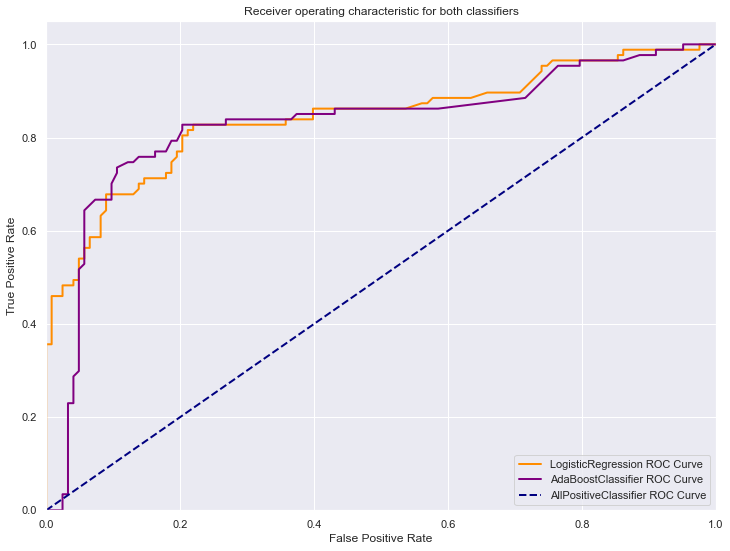

In [52]:
plt.figure(figsize=(12, 9))
lw = 2
plt.plot(fpr_lr, tpr_lr, color='darkorange',
         lw=lw, label='LogisticRegression ROC Curve')
plt.plot(fpr_ab, tpr_ab, color='purple',
         lw=lw, label='AdaBoostClassifier ROC Curve')
plt.plot(fpr_ap, tpr_ap, '--', color='navy',
         lw=lw, label='AllPositiveClassifier ROC Curve')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for both classifiers')
plt.legend(loc="lower right")
plt.show()

In [53]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, y_scores_lr)
precision_ab, recall_ab, thresholds_ab = precision_recall_curve(y_test, y_scores_ab)
precision_ap, recall_ap, thresholds_ap = precision_recall_curve(y_test, np.ones(shape=y_test.shape))

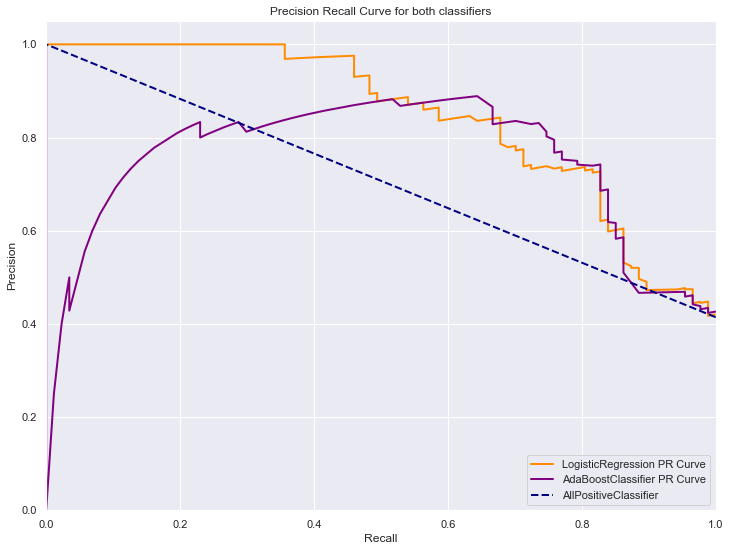

In [54]:
plt.figure(figsize=(12, 9))
lw = 2
plt.plot(recall_lr, precision_lr, color='darkorange',
         lw=lw, label='LogisticRegression PR Curve')
plt.plot(recall_ab, precision_ab, color='purple',
         lw=lw, label='AdaBoostClassifier PR Curve')
plt.plot(recall_ap, precision_ap, '--', color='navy',
         lw=lw, label='AllPositiveClassifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve for both classifiers')
plt.legend(loc="lower right")
plt.show()

#### Q3 (10 points)

Install `pyprg` for Area Under PRG calculation.

In [55]:
#!pip install pyprg

In [56]:
from sklearn.metrics import average_precision_score, roc_auc_score
from prg import prg

In [57]:
ab_auc_pr = average_precision_score(y_test, y_scores_ab)
ab_auc_roc = roc_auc_score(y_test, y_scores_ab)
ab_prg_curve = prg.create_prg_curve(y_test, y_scores_ab)
ab_auc_prg = prg.calc_auprg(ab_prg_curve)

lr_auc_pr = average_precision_score(y_test, y_scores_lr)
lr_auc_roc = roc_auc_score(y_test, y_scores_lr)
lr_prg_curve = prg.create_prg_curve(y_test, y_scores_ab)
lr_auc_prg = prg.calc_auprg(lr_prg_curve)

print(f"""
-- Area Under Precision Recall --
* Logistic Regression: {lr_auc_pr}
* AdaBoost Classifier: {ab_auc_pr}

-- Area Under ROC --
* Logistic Regression: {lr_auc_roc}
* AdaBoost Classifier: {ab_auc_roc}

-- Area Under Precision Recall Gain --
* Logistic Regression: {lr_auc_prg}
* AdaBoost Classifier: {ab_auc_prg}
""")


-- Area Under Precision Recall --
* Logistic Regression: 0.8444081506077105
* AdaBoost Classifier: 0.7429512094243728

-- Area Under ROC --
* Logistic Regression: 0.8427717035791049
* AdaBoost Classifier: 0.8290346696570414

-- Area Under Precision Recall Gain --
* Logistic Regression: 0.788933255126147
* AdaBoost Classifier: 0.788933255126147



I agree with the NIPS paper that AUPRG should be used, as it accounts for the negative examples.